In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import time as tm

## Variables de decisión de 1er etapa
$$x_{1}^{ij} = \left\lbrace \begin{array}{lc} 1 & \text{Si el individio j pertence al grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$
$$y_{1}^{i} = \left\lbrace \begin{array}{lc} 1 & \text{Si hay individuos en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$
$$z_{1}^{i} = \left\lbrace \begin{array}{lc} 1 & \text{Si hay más de un individuo en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

## Variables de decisión de 2da etapa

$$x_{2}^{ij} = \left\lbrace \begin{array}{lc} 1 & \text{Si el individio enfermo j pertence al grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$

$$ y_{2}^{i} = \left\lbrace \begin{array}{lc} 1 & \text{Si hay individuos enfermos en el grupo i}\\ 0 & \text{En otro caso} \end{array} \right.$$



## Restricciones

1. Relación de variables de decisión x e y.
$$ $$

2. Relación entre las variables x, z.
$$ $$

3. Todos los individuos tiene que estar en un grupo.
$$ $$

4. ~~La cantidad de grupos nos puede superar la cantidad de tests posibles.~~
$$ $$

5. ~~El grupo necesita cumplir el volumen de muestra minimo para que se realice un test.~~
$$ $$

6. ~~Si el individuo no tiene más de un umbral de muestra delta, entonces se realice un test individual inmediatamente.~~
$$ $$

7. La cantidad total de grupos de test (sin contar los test individuales) no puede superar a la cantidad de individuos dividida por el número de group testing.
$$ $$

8. La cantidad de individuos que conforman los grupos de test debe ser mayor o igual a la población total.

$$ $$
9. ~~Si la probabilidad de infección del individuo supera la probabilidad $p=0.3$ entonces se le hace un test individual (no implementado).~~


# Metodología de Dorfman

In [3]:
def Dorfman(model, where):

    if where == gp.GRB.Callback.MIPSOL:
        EQ = 0
        for s in escenarios:
            sub = gp.Model()
            sub.params.OutputFlag = 0

            x2 = sub.addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x2")
            y2 = sub.addVars(grupos, vtype=gp.GRB.BINARY, name="y2")
            sub.addConstrs(sum(x2[i, j] for j in individuos) <= GT for i in grupos)
            sub.addConstrs(y2[i]*1e6 >= sum(model.cbGetSolution(x1[GT][i, j]) * ret[s, j] for j in individuos) for i in grupos)
            sub.addConstrs(x2[i, j] >= model.cbGetSolution(x1[GT][i, j])*y2[i] + model.cbGetSolution(z1[GT][i])-1 for j in individuos for i in grupos)

            sub.setObjective(sum(x2[i, j] for i in grupos for j in individuos), gp.GRB.MINIMIZE)

            sub.optimize()
            EQ += sub.objVal
        EQ = EQ/S
        model.cbLazy(EQ <= theta[GT])

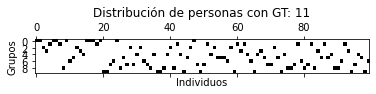

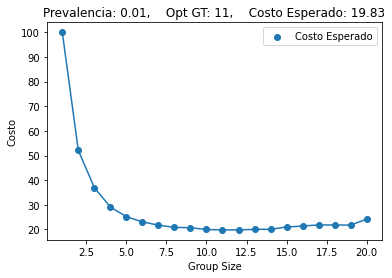

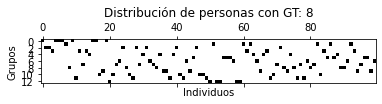

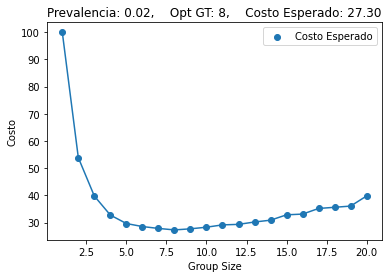

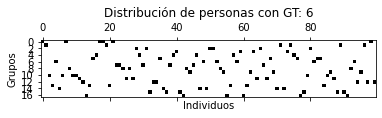

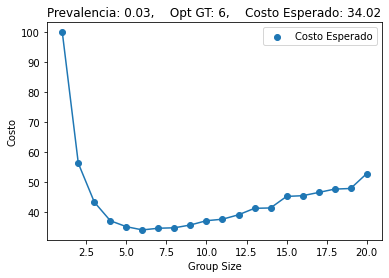

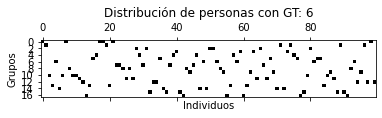

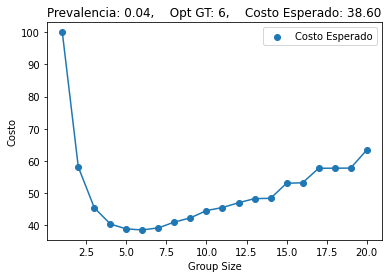

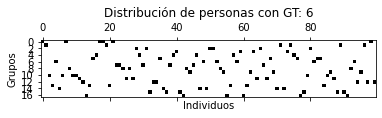

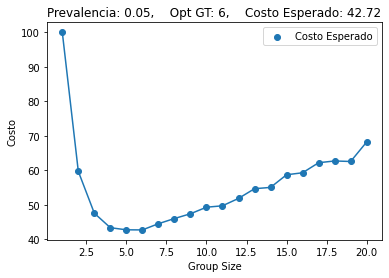

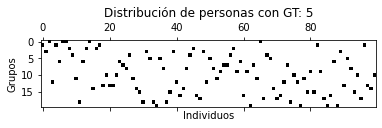

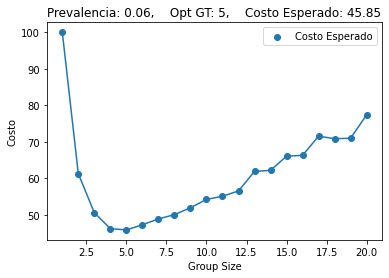

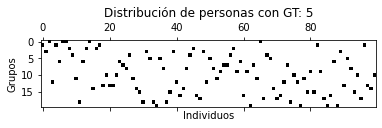

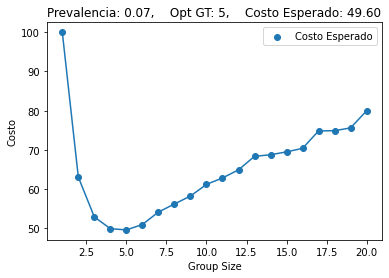

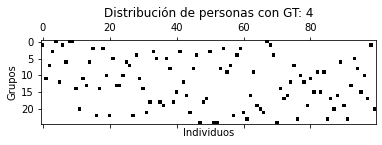

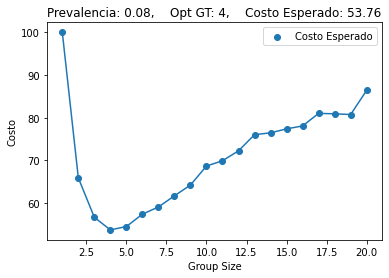

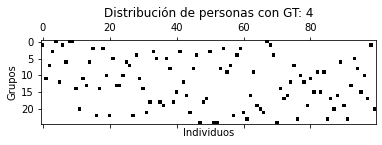

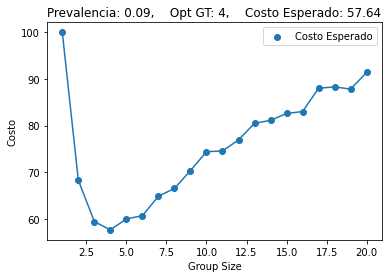

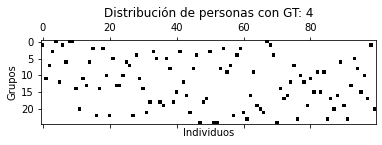

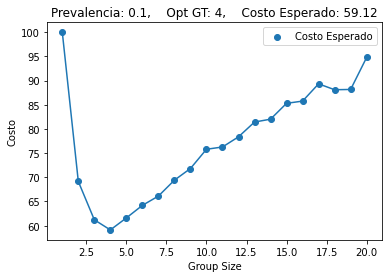

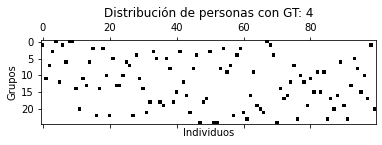

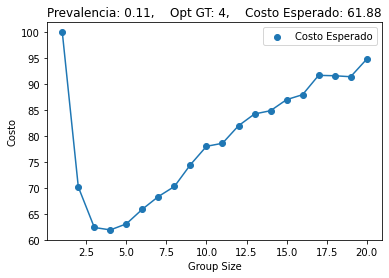

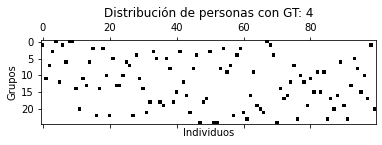

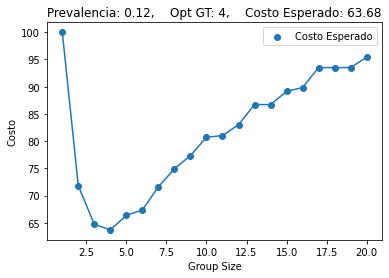

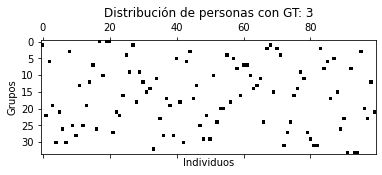

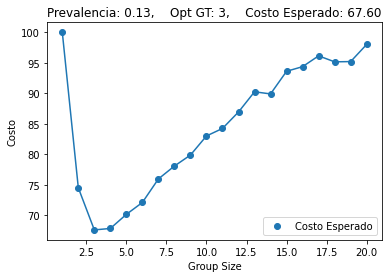

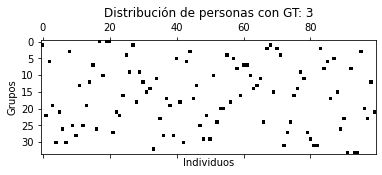

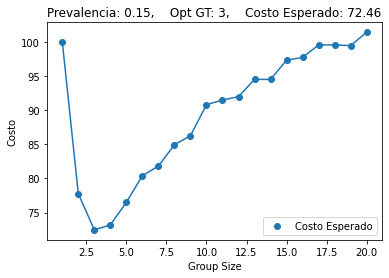

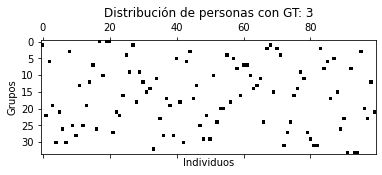

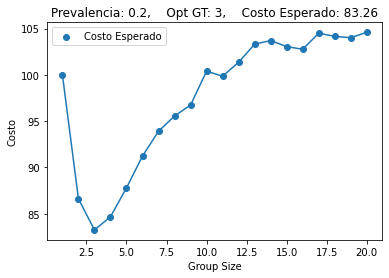

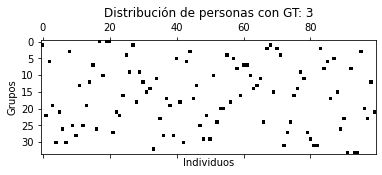

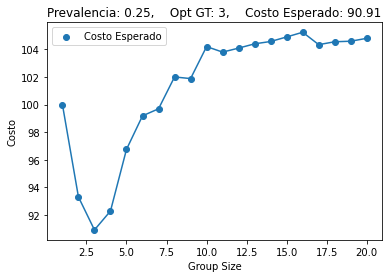

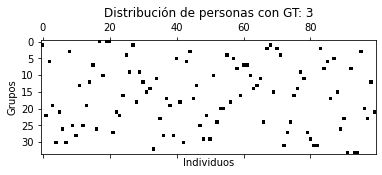

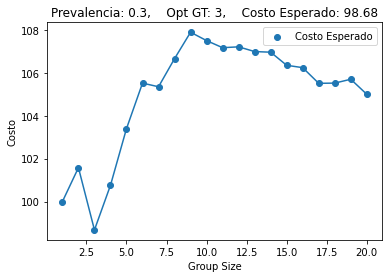

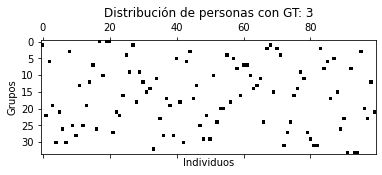

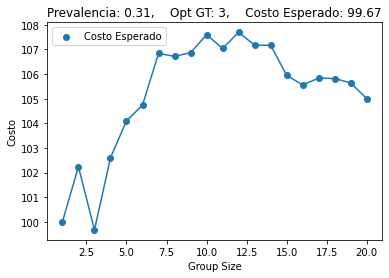

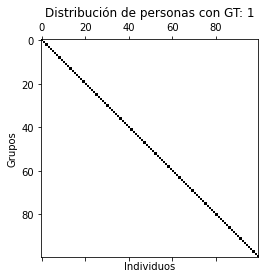

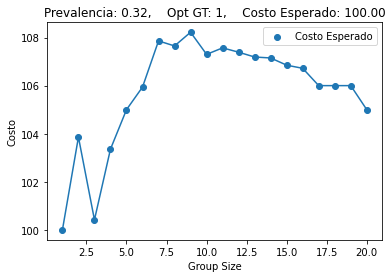

Tiempo de computo:  5796.59s


In [5]:
I = 100 # Cantidad de personas
S = 100 # Cantidad de escenarios
alpha = 5*I # Cantidad de test disponibles
beta = 0.2 # Cantidad de volumen de muestra que necesita un test
delta = 0.3 # Umbral para solo testear
individuos = range(I)
muestras = 2*np.ones(I)
escenarios = range(S)

prevalencia = [0.01, 0.02, 0.03, 0.04, 0.05, 
                0.06, 0.07, 0.08, 0.09, 0.10, 
                0.11, 0.12, 0.13, 0.15, 0.20, 
                0.25, 0.30, 0.31, 0.32]
costo = []
gt_opt = []

t1 = tm.time()
for p in prevalencia:
    hat_p = np.ones(I)*p
    ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])
    val = []

    x1 = {}
    y1 = {}
    z1 = {}
    theta = {}
    master = {}

    for GT in range(1,21):
        G = int(np.ceil(I/GT))
        grupos = range(G)
        L = 0
        
        master[GT] = gp.Model()
        master[GT].params.OutputFlag = 0
        master[GT].params.LazyConstraints = 1

        x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
        y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
        z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
        theta[GT] = master[GT].addVar(lb=L)

        master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
        master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
        master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
        # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
        # master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
        # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

        master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
        master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

        master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

        master[GT].optimize(Dorfman)
        val.append(master[GT].objVal)
            
    GTO = val.index(min(val)) + 1
    gt_opt.append(GTO)
    costo.append(master[GTO].objVal)
    G = int(np.ceil(I/GTO))

    M = np.zeros((G, I))
    i, j = -1, -1
    for var in master[GTO].getVars():
        if "x1" in var.VarName:
            # print(var)
            # print(var.X)
            j += 1
            if j % I == 0:
                i += 1
                j = 0

            if var.X == 1:
                M[i, j] = 1
    plt.spy(M)
    plt.title(f"Distribución de personas con GT: {GTO}")
    plt.ylabel("Grupos")
    plt.xlabel("Individuos")
    plt.show()

    plt.plot(range(1, len(val)+1), val)
    plt.scatter(range(1, len(val)+1), val, label="Costo Esperado")
    plt.title(f"Prevalencia: {p},    Opt GT: {GTO},    Costo Esperado: {master[GTO].objVal:0.2f}")
    plt.xlabel("Group Size")
    plt.ylabel("Costo")
    plt.legend()
    plt.show()

print(f"Tiempo de computo: {tm.time() - t1: 0.2f}s")


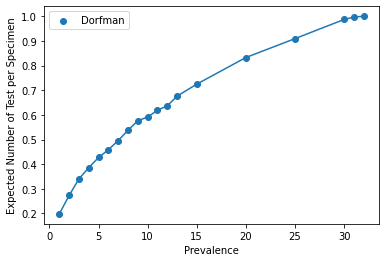

In [18]:
plt.plot(np.array(prevalencia)*100.0, np.array(costo)/100)
plt.scatter(np.array(prevalencia)*100.0, np.array(costo)/100, label="Dorfman")
plt.xlabel("Prevalence")
plt.ylabel("Expected Number of Test per Specimen")
plt.legend()


In [7]:
print("Prevalence Rate   Optimum Group   Relative Test")  
print("  per cent            Size             Cost    ")
for i in range(len(prevalencia)):
    print(f"{prevalencia[i]:^14.2f} | {gt_opt[i]:^14d} | {costo[i]:^14.2f}")

Prevalence Rate   Optimum Group   Relative Test
  per cent            Size             Cost    
     0.01      |       11       |     19.83     
     0.02      |       8        |     27.30     
     0.03      |       6        |     34.02     
     0.04      |       6        |     38.60     
     0.05      |       6        |     42.72     
     0.06      |       5        |     45.85     
     0.07      |       5        |     49.60     
     0.08      |       4        |     53.76     
     0.09      |       4        |     57.64     
     0.10      |       4        |     59.12     
     0.11      |       4        |     61.88     
     0.12      |       4        |     63.68     
     0.13      |       3        |     67.60     
     0.15      |       3        |     72.46     
     0.20      |       3        |     83.26     
     0.25      |       3        |     90.91     
     0.30      |       3        |     98.68     
     0.31      |       3        |     99.67     
     0.32      |      

In [4]:
print("Prevalence Rate   Optimum Group   Relative Test")  
print("  per cent            Size             Cost    ")
for i in range(len(prevalencia)):
    print(f"{prevalencia[i]:^14.2f} | {gt_opt[i]:^14d} | {costo[i]:^14.2f}")

Prevalence Rate   Optimum Group   Relative Test
  per cent            Size             Cost    
     0.01      |       11       |     18.80     
     0.02      |       8        |     26.53     
     0.03      |       6        |     33.92     
     0.04      |       5        |     38.40     
     0.05      |       5        |     43.20     
     0.06      |       5        |     48.50     
     0.07      |       4        |     50.44     
     0.08      |       4        |     53.28     
     0.09      |       4        |     56.52     
     0.10      |       4        |     59.96     
     0.11      |       4        |     63.80     
     0.12      |       3        |     65.23     
     0.13      |       4        |     67.72     
     0.15      |       4        |     72.08     
     0.20      |       3        |     82.60     
     0.25      |       3        |     92.68     
     0.30      |       3        |     97.84     
     0.31      |       1        |     100.00    
     0.32      |      

In [17]:
print("Prevalence Rate   Optimum Group   Relative Test")  
print("  per cent            Size             Cost    ")
for i in range(len(prevalencia)):
    print(f"{prevalencia[i]:^14.2f} | {gt_opt[i]:^14d} | {costo[i][gt_opt[i]-1]:^14.2f}")

Prevalence Rate   Optimum Group   Relative Test
  per cent            Size             Cost    
     0.01      |       11       |     19.89     
     0.02      |       8        |     27.58     
     0.03      |       6        |     34.12     
     0.04      |       6        |     38.14     
     0.05      |       5        |     42.95     
     0.06      |       5        |     46.45     
     0.07      |       5        |     51.50     
     0.08      |       4        |     53.84     
     0.09      |       4        |     56.32     
     0.10      |       4        |     60.60     
     0.11      |       4        |     63.32     
     0.12      |       3        |     66.28     
     0.13      |       4        |     66.76     
     0.15      |       3        |     72.49     
     0.20      |       3        |     82.81     
     0.25      |       3        |     92.08     
     0.30      |       3        |     99.34     


## Experimento 1
- Prevalencias reales desconocidas.
- Se asumen todas constantes con valor igual al promedio de las prevalencias desconocias.

### Procedimiento
1. Se toma un vector de prevalencias constantes y se calcula la configuración óptima 
2. Se teste el rendimiento de esta configuración usando las prevalencias reales

In [ ]:
I = 100  # Cantidad de personas
S = 100 # Cantidad de simulaciones
alpha = 5*I  # Cantidad de test disponibles
beta = 0.2  # Cantidad de volumen de muestra que necesita un test
delta = 0.3  # Umbral para solo testear

individuos = range(I)
muestras = 2*np.ones(I)
escenarios = range(S)

real_p = np.round(np.random.uniform(low=0.01, high=0.3, size=I), decimals=2)
hat_p = np.ones(I)*np.mean(real_p)

### Parte 1

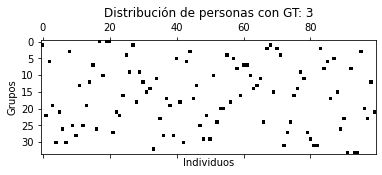

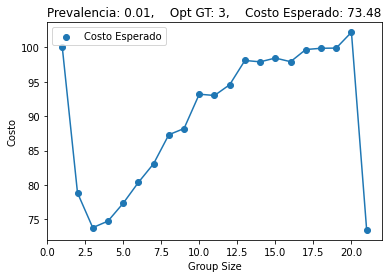

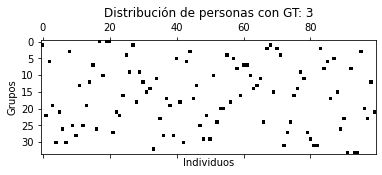

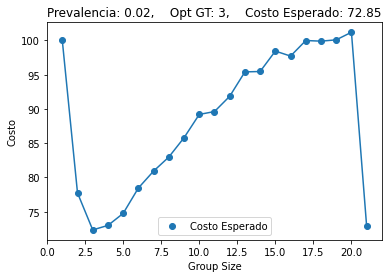

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 180, in gurobipy.CallbackClass.callback
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_7740\2779983742.py", line 13, in Dorfman
  File "src\gurobipy\model.pxi", line 3465, in gurobipy.Model.addConstrs
  File "C:\Users\jacmo\AppData\Local\Temp\ipykernel_7740\2779983742.py", line 13, in <genexpr>
KeyboardInterrupt: 


In [13]:
ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])

costo = []
gt_opt = []
val = []

x1 = {}
y1 = {}
z1 = {}
theta = {}
master = {}

for GT in range(1,int(I/2)+1):
    G = int(np.ceil(I/GT))
    grupos = range(G)
    L = 0
    
    master[GT] = gp.Model()
    master[GT].params.OutputFlag = 0
    master[GT].params.LazyConstraints = 1

    x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
    y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
    z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
    theta[GT] = master[GT].addVar(lb=L)

    master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
    master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
    master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
    # master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
    # master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
    # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
    # master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

    master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
    master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

    master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

    master[GT].optimize(Dorfman)
    val.append(master[GT].objVal)



hat_p = real_p   
ret = np.array([[np.random.binomial(n=1, p=x) for x in hat_p] for _ in escenarios])


GT = val.index(min(val)) + 1
G = int(np.ceil(I/GT))
grupos = range(G)
L = 0

master[GT] = gp.Model()
master[GT].params.OutputFlag = 0
master[GT].params.LazyConstraints = 1

x1[GT] = master[GT].addVars(grupos, individuos, vtype=gp.GRB.BINARY, name="x1")
y1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="y1")
z1[GT] = master[GT].addVars(grupos, vtype=gp.GRB.BINARY, name="z1")
theta[GT] = master[GT].addVar(lb=L)

master[GT].addConstrs(y1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) for i in grupos) #R1
master[GT].addConstrs(z1[GT][i]*1e6 >= sum(x1[GT][i, j] for j in individuos) - 1 for i in grupos) #R2
master[GT].addConstrs(sum(x1[GT][i, j] for i in grupos) >= 1 for j in individuos) #R3
# master[GT].addConstr(sum(y1[GT][i] for i in grupos) <= alpha) #R4
# master[GT].addConstrs(sum(muestras[j]*x1[GT][i,j] for i in grupos) >= beta for j in individuos) #R5
# master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos) #R6
# master[GT].addConstrs((muestras[j] <= delta) >> (sum(x1[GT][i,j] for i in grupos) == 1) for j in individuos)

master[GT].addConstrs(sum(x1[GT][i, j] for j in individuos) <= GT for i in grupos) #R7
master[GT].addConstr(sum(x1[GT][i, j] for i in grupos for j in individuos) >= I) #R8

master[GT].setObjective(sum(y1[GT][j] for j in grupos) + theta[GT], gp.GRB.MINIMIZE)

master[GT].optimize(Dorfman)
val.append(master[GT].objVal)


gt_opt.append(GTO)
costo.append(master[GTO].objVal)

M = np.zeros((G, I))
i, j = -1, -1
for var in master[GTO].getVars():
    if "x1" in var.VarName:
        # print(var)
        # print(var.X)
        j += 1
        if j % I == 0:
            i += 1
            j = 0

        if var.X == 1:
            M[i, j] = 1
plt.spy(M)
plt.title(f"Distribución de personas con GT: {GTO}")
plt.ylabel("Grupos")
plt.xlabel("Individuos")
plt.show()

plt.plot(range(1, len(val)+1), val)
plt.scatter(range(1, len(val)+1), val, label="Costo Esperado")
plt.title(f"Prevalencia: {p},    Opt GT: {GTO},    Costo Esperado: {master[GTO].objVal:0.2f}")
plt.xlabel("Group Size")
plt.ylabel("Costo")
plt.legend()
plt.show()

# print(f"Tiempo de computo: {tm.time() - t1: 0.2f}s")


### Parte 2